# Économétrie pure

On veut valider empiriquement l'équation suivante : 
$$\phi_{t}^{i} = \frac{1}{c_{\phi}^{i}}(P^{i}-A^{i}(E_{t}^{i}-\Psi_{t}^{i}))$$
Avec : 
- $\phi_{t}^{i}$: Flux mensuel de communication environnementale au mois $t$ pour l'entreprise $i$.
- $c_{t}^{i}$: Coût marginal de communication.
- $E_{t}^{i}$: Score environnemental au mois $t$ pour l'entreprise $i$.
- $\Psi_{t}^{i}$: Valeur environnementale fondamentale de l'entreprise $i$ au mois $t$.


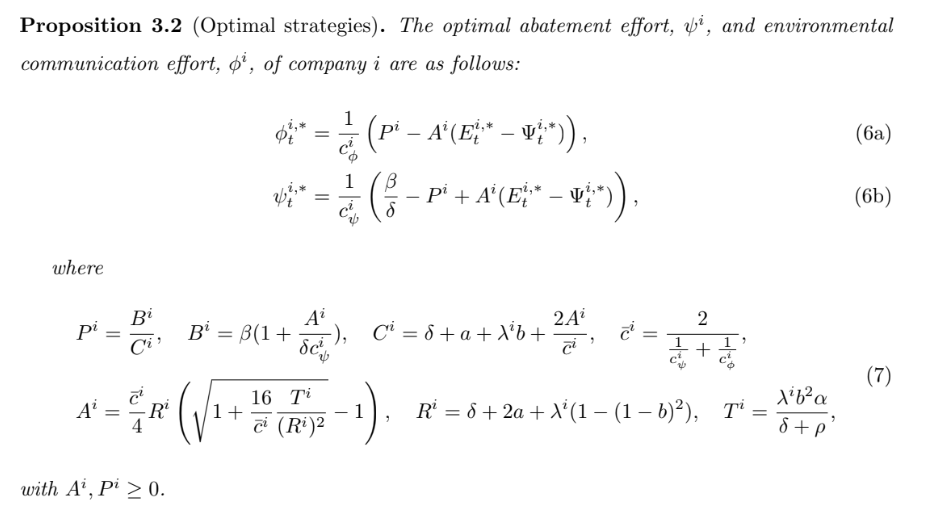

## 1st step

On cherche à construire un proxy $\hat{\phi}^{i}_{t}$ pour $\phi^{i}_{t}$. 


Nous construisons un score de communication environnementale, $\hat{\varepsilon}^{i}_{1,t}$, purifié de l'effet des controverses environnementales, défini comme les résidus de la régression Within de $Rep^{i}_{t}$ sur $Con^{i}_{t}$ avec des effets fixes dans le temps et pour l'entreprise, où $Con^{i}_{t}$ est instrumenté par $Con^{i}_{t-1}$ :
\begin{equation}
Rep^{i}_{t} = \alpha^{i}_{1,1} + \alpha_{1,2,t} + \beta_1 Con^{i,*}_{t} + \varepsilon^{i}_{1,t}
\end{equation}

où $Con^{i,*}_{t} = \hat{\beta}_2 Con^{i}_{t-1}$ est la prédiction de la régression suivante :
\begin{equation}
Con^{i}_{t} = \alpha^{i}_{2,1} + \alpha_{2,2,t} + \beta_2 Con^{i}_{t-1} + \varepsilon^{i}_{2,t}.
\end{equation}

--------------- TESTER PERTINENCE DE L'INSTRUMENT ----------------

Le test de pertinence de l'instrument $Con^{i}_{t}$ donne un $R^2$ de la régression de $Con^{i}_{t}$ sur $Con^{i}_{t-1}$ de 78,3\%. De plus, la condition d'exogénéité faible est satisfaite, assurant que les résidus de la régression 2SLS peuvent être utilisés pour construire un proxy du score de communication environnementale. Nous définissons alors un proxy du flux de communication environnementale, $\hat{\varphi}^{i}_{t}$, comme la première différence du score de communication environnementale :
\begin{equation}
\hat{\varphi}^{i}_{t} \equiv \hat{\varepsilon}^{i}_{1,t} - \hat{\varepsilon}^{i}_{1,t-1}.
\end{equation}

Ce proxy représente le flux de communication environnementale de l'entreprise i au mois t.

In [1]:
!pip3 install openpyxl
!pip3 install linearmodels
import pandas as pd
import numpy as np
import linearmodels

from linearmodels.panel import PanelOLS, FirstDifferenceOLS
from linearmodels.iv import IV2SLS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.3 MB/s eta 0:00:00


### Etape 1 : Construire la variable Con_star

#### Construction de Con_star

In [30]:
df = pd.read_pickle('data_pannels.pkl')

# Convertir la colonne 'Date' en type datetime
df['Date'] = pd.to_datetime(df['Date'])

df['Controverse'] = df['Controverse'].str.replace(',', '.').astype(float)
df['ESG'] = df['ESG'].str.replace(',', '.').astype(float)


# Définir l'index sur les colonnes 'idEntreprise' et 'Date'
df.set_index(['idEntreprise', 'Date'], inplace=True)

df['Con_lag'] = df.groupby(level=0)['Controverse'].shift(1)

df

score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.332623  82.539668  93.292759  0.283145   
             2009-02-01   -0.230199  82.542735  93.560074  0.264490   
             2009-03-01   -0.306089  82.579781  90.820477  0.122571   
             2009-04-01   -0.455418  83.709127  91.262384  0.077381   
             2009-05-01   -0.462011  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447711  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448874  51.439231  50.000000 -0.928834   
             2023-02-01   -0.447561  51.435447  50.000000 -0.925788   
             2023-03-01   -0.449399  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451303  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag  
idEntreprise Date                                
116          2009-01-01    82.539668        NaN  
             2009-02-01    82.542735  82.539668  
             2009-03-01    82.579781  82.542735  
             2009-04-01    83.709127  82.579781  
             2009-05-01    84.134502  83.709127  
...                              ...        ...  
18970        2022-12-01    51.443093  51.447034  
             2023-01-01    51.439231  51.443093  
             2023-02-01    51.435447  51.439231  
             2023-03-01    51.431738  51.435447  
             2023-04-01    51.705881  51.431738  

[12212 rows x 6 columns]

In [32]:
from linearmodels.panel import PanelOLS

# Première étape: Régression de Con sur Con_lag avec effets fixes
first_stage = PanelOLS(dependent=df['Controverse'], 
                       exog=df[['Con_lag']],
                       entity_effects=True, 
                       time_effects=True)
res_first_stage = first_stage.fit()

# Ajouter les valeurs ajustées à df
df['Con_star'] = res_first_stage.fitted_values

df

/opt/mamba/lib/python3.11/site-packages/linearmodels/panel/model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


score_comm        ESG        PFL    Diff_z  \
idEntreprise Date                                                     
116          2009-01-01   -0.332623  82.539668  93.292759  0.283145   
             2009-02-01   -0.230199  82.542735  93.560074  0.264490   
             2009-03-01   -0.306089  82.579781  90.820477  0.122571   
             2009-04-01   -0.455418  83.709127  91.262384  0.077381   
             2009-05-01   -0.462011  84.134502  91.953853  0.091482   
...                             ...        ...        ...       ...   
18970        2022-12-01   -0.447711  51.443093  50.000000 -0.930035   
             2023-01-01   -0.448874  51.439231  50.000000 -0.928834   
             2023-02-01   -0.447561  51.435447  50.000000 -0.925788   
             2023-03-01   -0.449399  51.431738  50.000000 -0.927918   
             2023-04-01   -0.451303  51.705881  50.000000 -0.923323   

                         Controverse    Con_lag   Con_star  
idEntreprise Date                                           
116          2009-01-01    82.539668        NaN        NaN  
             2009-02-01    82.542735  82.539668  81.593674  
             2009-03-01    82.579781  82.542735  81.596706  
             2009-04-01    83.709127  82.579781  81.633327  
             2009-05-01    84.134502  83.709127  82.749730  
...                              ...        ...        ...  
18970        2022-12-01    51.443093  51.447034  50.857395  
             2023-01-01    51.439231  51.443093  50.853499  
             2023-02-01    51.435447  51.439231  50.849682  
             2023-03-01    51.431738  51.435447  50.845941  
             2023-04-01    51.705881  51.431738  50.842274  

[12212 rows x 7 columns]

#### Analyse de Con_star et de sa régression

In [33]:
print(res_first_stage)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.9679
Estimator:                   PanelOLS   R-squared (Between):              0.9999
No. Observations:               12141   R-squared (Within):               0.9686
Date:                Tue, Apr 16 2024   R-squared (Overall):              0.9996
Time:                        09:33:10   Log-likelihood                -1.363e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.592e+05
Entities:                          71   P-value                           0.0000
Avg Obs:                       171.00   Distribution:                 F(1,11899)
Min Obs:                       171.00                                           
Max Obs:                       171.00   F-statistic (robust):          3.592e+05
                            

In [34]:
print(res_first_stage.params)

Con_lag    0.988539
Name: parameter, dtype: float64


In [35]:
print(df['Con_star'])

idEntreprise  Date      
116           2009-01-01          NaN
              2009-02-01    81.593674
              2009-03-01    81.596706
              2009-04-01    81.633327
              2009-05-01    82.749730
                              ...    
18970         2022-12-01    50.857395
              2023-01-01    50.853499
              2023-02-01    50.849682
              2023-03-01    50.845941
              2023-04-01    50.842274
Name: Con_star, Length: 12212, dtype: float64


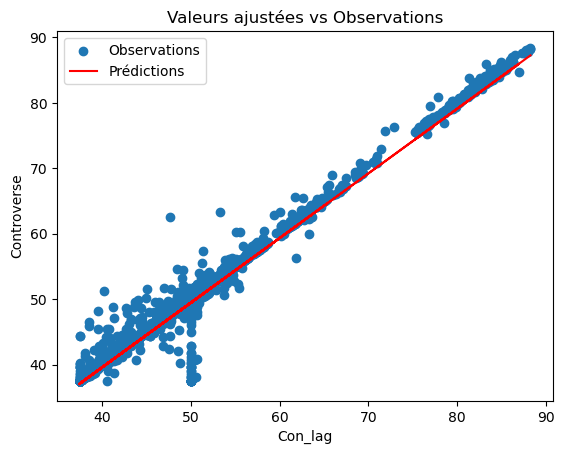

In [36]:
import matplotlib.pyplot as plt

plt.scatter(df['Con_lag'], df['Controverse'], label='Observations')
plt.plot(df['Con_lag'], df['Con_star'], color='red', label='Prédictions')
plt.xlabel('Con_lag')
plt.ylabel('Controverse')
plt.legend()
plt.title('Valeurs ajustées vs Observations')
plt.show()

On peut faire une test d'hétéroscédasticité sur cette régression !?

Test de Hausman : Le test de Hausman est utilisé pour évaluer la spécification appropriée des modèles de régression dans lesquels il y a une incertitude sur le choix entre des effets fixes et des effets aléatoires. Plus spécifiquement, il est utilisé dans les modèles de panel pour déterminer si les effets fixes sont préférables aux effets aléatoires.

In [43]:
from linearmodels.panel import compare
from linearmodels.panel import RandomEffects

# Créer un modèle RandomEffects
random_effects_model = RandomEffects(df['Controverse'], df[['Con_lag']])

# Ajuster le modèle
res_random_effects = random_effects_model.fit()

# Comparer les estimations des effets fixes et des effets aléatoires
hausman_test = compare({'Effets Fixes': res_first_stage, 'Effets Aléatoires': res_random_effects})
print(hausman_test)

                     Model Comparison                    
                           Effets Fixes Effets Aléatoires
---------------------------------------------------------
Dep. Variable               Controverse       Controverse
Estimator                      PanelOLS     RandomEffects
No. Observations                  12141             12141
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.9679            0.9998
R-Squared (Within)               0.9686            0.9685
R-Squared (Between)              0.9999            1.0000
R-Squared (Overall)              0.9996            0.9998
F-statistic                   3.592e+05         4.918e+07
P-value (F-stat)                 0.0000            0.0000
=====================     =============   ===============
Con_lag                          0.9885            0.9999
                               (599.37)          (7012.8)
======================= =============== =================
Effects       

/opt/mamba/lib/python3.11/site-packages/linearmodels/panel/model.py:2618: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


    Hypothèse Nulle (H0) : Les estimateurs des effets fixes sont cohérents et efficaces, mais non nécessairement les plus efficaces. Cela signifie que les effets fixes sont appropriés dans le modèle.

    Hypothèse Alternative (H1) : Les estimateurs des effets fixes ne sont pas seulement inefficaces mais aussi biaisés. Cela suggère que les effets aléatoires sont plus appropriés dans le modèle.

Statistique de test :

La statistique de test utilisée dans le test de Hausman est généralement basée sur la différence entre les estimateurs des effets fixes et des effets aléatoires. Cette statistique suit approximativement une distribution de chi carré sous l'hypothèse nulle.

Ici, p-value est de 0, on rejette l'hypothèse nulle. Les estimateurs des effets fixes sont biaisés et inefficaces. Il semblerait qu'il est préférable d'utiliser des effets aléatoire (comme en régression classique) que des effets fixes (les alpha i dans les pannels).

### Etape 2 : 

In [3]:


# Deuxième étape: Régression 2SLS de Rep sur Con instrumenté par Con_star avec effets fixes
instrumented_variable = df['Con_star']
dependent_variable = df['Rep']
exogenous_variables = pd.DataFrame({'const': 1})  # Ajouter d'autres variables exogènes si nécessaire
exogenous_variables.index = df.index

second_stage = IV2SLS(dependent_variable, exogenous_variables, instrumented_variable, None).fit()
df['epsilon_hat'] = second_stage.resids

# Calcul du proxy du flux de communication environnementale
df['phi_hat'] = df.groupby(level=0)['epsilon_hat'].diff()


ValueError: The index on the time dimension must be either numeric or date-like

# Le reste du code

In [ ]:
def get_user_date(start_date, end_date):
    # Prompt the user for a date
    user_date_str = input(f"Enter a date between {start_date} and {end_date} (format YYYY-MM): ")
    
    # Convert user input to a pandas Timestamp
    try:
        user_date = pd.to_datetime(user_date_str, format='%Y-%m')
        start_date = pd.to_datetime(start_date, format='%Y-%m')
        end_date = pd.to_datetime(end_date, format='%Y-%m')

        # Check if the date is within the range
        if start_date <= user_date <= end_date:
            print(f"Selected date: {user_date.strftime('%Y-%m')}")
            return user_date
        else:
            print("Date is out of range. Please try again.")
            return None
    except ValueError:
        print("Invalid date format. Please try again.")
        return None

# Example usage
get_user_date("2002-01", "2023-04")


In [ ]:
# On laisse l'utilisateur choisir une date
date_debut="2002-01"
date_fin="2023-04"
t = get_user_date(date_debut,date_fin)
t = pd.to_datetime(t, format='%Y-%m')
t_minus_1 = (t - pd.DateOffset(months=1)).strftime('%Y-%m')
print(t_minus_1)

# On recupère les scores des etp aux dates t et t-1
col_index = esg_data.columns.get_loc(t)
esge_t = esg_data.iloc[:, col_index]
col_index = esg_data.columns.get_loc(t_minus_1)
esge_t_minus_1 = esg_data.iloc[:, col_index]

In [ ]:
data = {
    'env_comm_score': env_comm_score, 
    'esge': esge_t
    'esge_past': esge_t_minus_1
    'esge_peer': np.random.uniform(0, 100, 100)  # 100 peer environmental scores in the same sector
}

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Define your variables
dependent = df['env_comm_score']
independent = df[['const']]  # Assuming you've added a constant term to your DataFrame
instrument = df['esge_past']  # Instrumenting esge with its past value
endogenous = df['esge']  # The variable you believe is endogenous

# Setup and run the 2SLS regression
model = IV2SLS(dependent, independent, endogenous, instrument).fit()

# Print model summary
print(model.summary)

# To instrument 'esge' with both its past value and peer scores, you might do:
instrument2 = df[['esge_past', 'esge_peer']]
model2 = IV2SLS(dependent, independent, endogenous, instrument2).fit()
print(model2.summary)
